## Convolutional Neural Networks

In [1]:
# FIX ALL THE RANDOM VALUES TO GET REPRODUCIBLE RESULTS
import os
os.environ["PYTHONHASHSEED"] = "0"

import random as rn
rn.seed(1254)

import numpy as np
np.random.seed(1515)

# SET NICE PLOTTING
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import librosa, librosa.display, IPython.display as ipd
from tqdm import tqdm
import glob
import pandas as pd
import h5py
from sklearn import preprocessing
import pickle

In [2]:
plt.rcParams['figure.figsize'] = (14, 6)

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import tensorflow as tf
tf.set_random_seed(2)

config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1 
)

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(graph= tf.get_default_graph(), config=config) 
    
import keras 
from keras import backend as K
K.set_session(sess)  # set this TensorFlow session as the default session for Keras

from keras.layers import Input, Conv2D, MaxPooling2D, LSTM
from keras.layers import Dense, Flatten
from keras.layers.core import Dropout
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [4]:
#SET PATHS
dataspace = '/vol/vssp/datasets/audio01/UrbanSound8K/audio/'
projectspace = '/vol/vssp/AcousticEventsDetection/DLGdansk/UrbanSound/'

metadatafile = '/vol/vssp/datasets/audio01/UrbanSound8K/metadata/UrbanSound8K.csv'
metadata = pd.read_csv(metadatafile)

hdf5_path = os.path.join(projectspace,'dataset.hdf5') 
modelfolder = os.path.join(projectspace,'models')
scalerpath = os.path.join(projectspace,'scaler.pkl')

In [5]:
# LOAD DATA
hf = h5py.File(hdf5_path, 'r')
X_train = np.array(hf.get('X_train') )
y_train = np.array(hf.get('y_train'))
X_val =  np.array(hf.get('X_val'))
y_val= np.array(hf.get('y_val'))
X_test = np.array(hf.get('X_test'))
y_test = np.array(hf.get('y_test'))

n_features= hf.get('n_features').value
n_frames=hf.get('max_length_samp').value
label_list= hf.get('label_list').value

In [6]:
# SCALE THE DATA
scaler=pickle.load(open(scalerpath, 'rb'))

X_train_scaled = [scaler.transform(x.T) for x in X_train]
X_val_scaled = [scaler.transform(x.T) for x in X_val]
X_test_scaled = [scaler.transform(x.T) for x in X_test]

# CHANGE DIMENSION TO FIT KERAS
X_train = np.expand_dims(X_train_scaled, 3)
X_val = np.expand_dims(X_val_scaled, 3)
X_test = np.expand_dims(X_test_scaled, 3)

In [7]:
def build_cnn(n_frames=n_frames, n_features=n_features,  n_filters_cnn=48,
                     filter_size_cnn=(3, 3), pool_size_cnn=(2,2),
                     n_classes=10):

    # INPUT
    x = Input(shape=(n_frames, n_features,  1), dtype='float32')

    # CONV 1
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid', kernel_regularizer=l2(0.01),
               activation='relu')(x)
    y = MaxPooling2D(pool_size=pool_size_cnn, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)

    # CONV 2
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid',kernel_regularizer=l2(0.01),
               activation='relu')(y)
    y = MaxPooling2D(pool_size=pool_size_cnn, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)

    # CONV 3
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid',kernel_regularizer=l2(0.01),
               activation='relu')(y)
    y = MaxPooling2D(pool_size=pool_size_cnn, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)

    # Flatten for dense layers
    y = Flatten()(y)

    y = Dropout(0.5)(y)
    y = Dense(n_classes, activation='sigmoid')(y)

    m = Model(inputs=x, outputs=y)
    return m

In [8]:
m = build_cnn(n_features=40,)
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 173, 40, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 171, 38, 48)       480       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 19, 48)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 85, 19, 48)        192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 83, 17, 48)        20784     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 41, 8, 48)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 41, 8, 48)         192       
__________

In [9]:
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
model_checkpoint = ModelCheckpoint(
    os.path.join(modelfolder, 'cnn_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.hdf5'),
    monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
callbacks = [early_stopping, model_checkpoint]

history = m.fit(x=X_train, y=y_train, batch_size=130,
                    epochs=200, verbose=True,
                    validation_split=0.0,                
                    callbacks=callbacks,
                    validation_data=(X_val, y_val), shuffle=True)

Train on 7079 samples, validate on 816 samples
Epoch 1/200
7079/7079 [==============================] - 6s 857us/step - loss: 2.6079 - acc: 0.3657 - val_loss: 2.9409 - val_acc: 0.2390
Epoch 2/200
7079/7079 [==============================] - 4s 537us/step - loss: 1.9632 - acc: 0.5413 - val_loss: 3.3493 - val_acc: 0.1029
Epoch 3/200
7079/7079 [==============================] - 4s 516us/step - loss: 1.5519 - acc: 0.6632 - val_loss: 3.3488 - val_acc: 0.1127
Epoch 4/200
7079/7079 [==============================] - 3s 453us/step - loss: 1.2787 - acc: 0.7336 - val_loss: 3.5090 - val_acc: 0.1213
Epoch 5/200
7079/7079 [==============================] - 3s 481us/step - loss: 1.0707 - acc: 0.7870 - val_loss: 3.2522 - val_acc: 0.2831
Epoch 6/200
7079/7079 [==============================] - 3s 479us/step - loss: 0.9178 - acc: 0.8176 - val_loss: 3.4371 - val_acc: 0.2966
Epoch 7/200
7079/7079 [==============================] - 3s 468us/step - loss: 0.8170 - acc: 0.8494 - val_loss: 3.0452 - val_acc: 0

7079/7079 [==============================] - 3s 477us/step - loss: 0.2753 - acc: 0.9627 - val_loss: 2.2982 - val_acc: 0.7022
Epoch 61/200
7079/7079 [==============================] - 3s 475us/step - loss: 0.2862 - acc: 0.9585 - val_loss: 2.2459 - val_acc: 0.7316
Epoch 62/200
7079/7079 [==============================] - 3s 494us/step - loss: 0.2570 - acc: 0.9672 - val_loss: 2.0420 - val_acc: 0.7623
Epoch 63/200
7079/7079 [==============================] - 3s 442us/step - loss: 0.2397 - acc: 0.9719 - val_loss: 2.1890 - val_acc: 0.7439
Epoch 64/200
7079/7079 [==============================] - 3s 486us/step - loss: 0.2327 - acc: 0.9730 - val_loss: 1.9408 - val_acc: 0.7574
Epoch 65/200
7079/7079 [==============================] - 3s 469us/step - loss: 0.2404 - acc: 0.9702 - val_loss: 2.1287 - val_acc: 0.7390
Epoch 66/200
7079/7079 [==============================] - 3s 479us/step - loss: 0.2447 - acc: 0.9677 - val_loss: 2.5567 - val_acc: 0.6998
Epoch 67/200
7079/7079 [=======================

In [11]:
prediction = m.predict(X_test, batch_size=130, verbose=1)
y_predict=np.array([ np.argmax(p) for p in prediction])
y_test_label = np.array([np.argmax(y) for y in y_test])

837/837 [==============================] - 0s 457us/step


Accuracy: 0.68


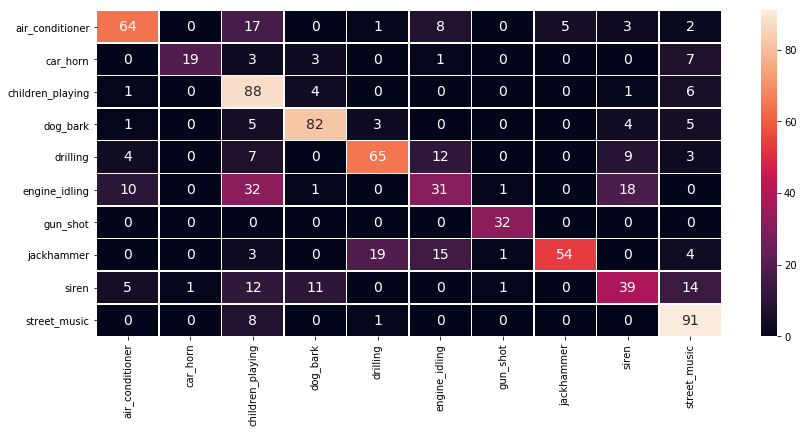

In [12]:
from sklearn.metrics import confusion_matrix
acc = np.sum(y_test_label==y_predict) / float(len(y_test_label))
print('Accuracy: {:.2f}'.format(acc))

cm = confusion_matrix(y_test_label, y_predict )
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5, yticklabels=label_list,xticklabels=label_list)

In [13]:
K.clear_session()